# Preamble 

In [4]:
wld_dir = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD'
wld_pkg = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/WeakLensingDeblending'

import os
os.chdir(wld_dir)

%matplotlib inline

import mycode.tomo.tomo_fncs as tomo_fncs
import mycode.errors as errors
import mycode.preamble as preamble
import mycode.weights as weights 
import mycode.maps as maps 
import corner 
from tqdm import tqdm 

%run mycode/preamble.py

from importlib import reload
reload(errors)
reload(weights)
reload(preamble)
reload(maps)
reload(corner)

<module 'corner' from '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/miniconda3/envs/igalsim/lib/python3.7/site-packages/corner/__init__.py'>

## reload 

In [3]:
reload(tomo_fncs)
reload(errors)
reload(preamble)

<module 'mycode.preamble' from '/Users/Ismael/code/lensing/WLD/mycode/preamble.py'>

# Simulate with pinv 

In [3]:
galaxy_dx = -149.79222/ 3600
galaxy_dy= -1514.9642/3600
print(galaxy_dx,galaxy_dy)

-0.04160895 -0.42082338888888887


In [6]:
# # #this displays all 77 galaxies pertaining to this group using pinv
# subprocess.run(f"./WeakLensingDeblending_pinv/simulate.py --catalog-name OneDegSq.fits --image-width 600 --image-height 600\
#                --ra-center {galaxy_dx} --dec-center {galaxy_dy}\
#                --survey-name LSST --filter-band i --output-name demo1_test --verbose",shell=True)



KeyboardInterrupt: 

In [4]:
# #simulate one of the 100 boxes where the above galaxy and its group is found using pinv. 
# subprocess.run(f" ./WeakLensingDeblending/simulate.py --catalog-name OneDegSq.fits --image-width 1800 --image-height 1800\
#                --ra-center -0.05 --dec-center -0.45\
#                --survey-name LSST --filter-band i --output-name demo2 --verbose",shell=True)

CompletedProcess(args=' ./WeakLensingDeblending/simulate.py --catalog-name OneDegSq.fits --image-width 1800 --image-height 1800               --ra-center -0.05 --dec-center -0.45               --survey-name LSST --filter-band i --output-name demo2 --verbose', returncode=0)

In [75]:
# subprocess.run(f"./WeakLensingDeblending/simulate.py --catalog-name OneDegSq.fits --image-width 600 --image-height 600\
#                --ra-center {galaxy_dx} --dec-center {galaxy_dy}\
#                --survey-name LSST --filter-band i --output-name demo1_pinv_bias --verbose --calculate-bias",shell=True)

CompletedProcess(args='./WeakLensingDeblending/simulate.py --catalog-name OneDegSq.fits --image-width 600 --image-height 600               --ra-center -0.04160895 --dec-center -0.42082338888888887               --survey-name LSST --filter-band i --output-name demo1_pinv_bias --verbose --calculate-bias', returncode=0)

# Read results 

In [4]:
#first patch 400x400 , second 1800x1800
cats = {
    'demo1_pinv': Table.read('demo1_pinv.fits'),
    'demo2_pinv': Table.read('demo2_pinv.fits'),
    
    'demo1_pinv2': Table.read('demo1_pinv2.fits'),
    'demo2_pinv2': Table.read('demo2_pinv2.fits'),
    
    'demo2': Table.read('demo2.fits')
}

## Reinvestigate the problematic patches 

In [ ]:
#recall interested galaxy db_id = 402700857466
#and group grp_id = 402700140027

## compare the snr_grpf of the galaxies in the group we are interested in. 

In [116]:
cat1_grp = cat1[cat1['grp_id']==402700140027]
cat1_grp.sort('db_id')

cat2_grp = cat2[cat2['grp_id']==402700140027]
cat2_grp.sort('db_id')


snr_grpfs1 = cat1_grp['snr_grpf']
snr_grpfs2 = cat2_grp['snr_grpf']

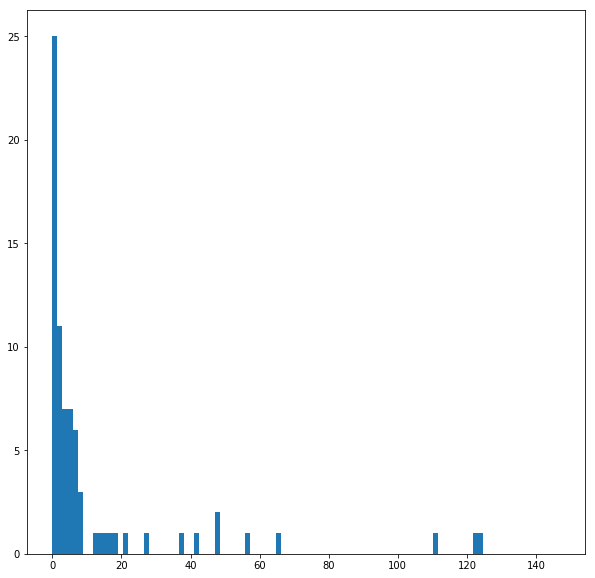

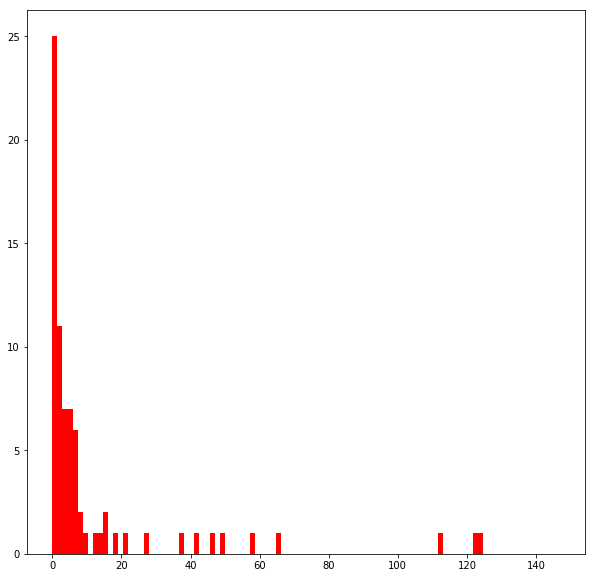

In [117]:
# plt.figure(figsize=(10,10))
# plt.hist(snr_grpfs1, bins=100, range=(0,np.percentile(snr_grpfs1,98)) );

# plt.figure(figsize=(10,10))
# plt.hist(snr_grpfs2, bins=100, range=(0,np.percentile(snr_grpfs1,98)),color='r' );

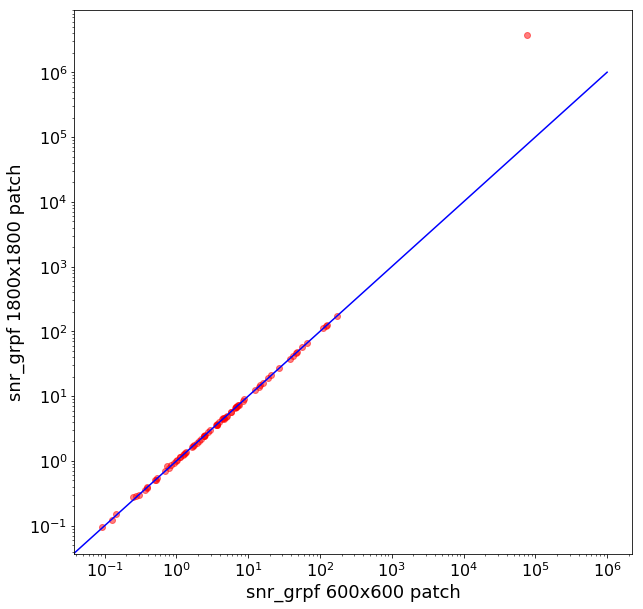

In [121]:
plt.figure(figsize=(10,10))
plt.scatter(snr_grpfs1, snr_grpfs2, c='r', alpha=0.5)

# plt.xlim(0,140)
# plt.ylim(0,140)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("snr_grpf 600x600 patch", size = 18)
plt.ylabel("snr_grpf 1800x1800 patch", size = 18)



plt.tick_params(axis='both', which='major', labelsize=16) 
plt.plot([0,1e6],[0,1e6],c='b')

## what condition must snr_isof and snr_grpf satisfy? 

### using pinv 

In [21]:
cat = cats['demo2_pinv']

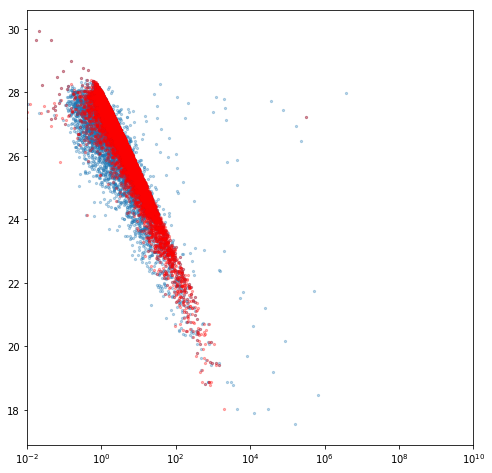

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(cat['snr_grpf'], cat['ab_mag'], alpha=0.3, s=5)
plt.scatter(cat['snr_isof'], cat['ab_mag'], alpha=0.3, s=5, c='r')
plt.xlim(1e-2,1e10)
plt.xscale('log')

In [22]:
print(len(cat[cat['snr_grpf'] > cat['snr_isof']]))
print(len(cat[cat['snr_grpf'] <= cat['snr_isof']]))

284
8498


In [ ]:
###investigate this galaxy. 

In [168]:
cat2[(cat2['snr_isof'] > 1e3) & (cat2['snr_grpf'] > cat2['snr_isof']) ]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402700010705,402700010705,46,0,1,1637,1746,1023,1164,0.82090735,0.17909265,158.425,38.79283,0.1819539,18.036911,0.46804428,43369376.0,1.6547087,1.8483996,-0.325368,-0.06618839,2.3366897,1.1717693,-1.4704524,1.7895656,0.9953629,4165.1733,3229.9854,3228.7073,1994.942,4506.6025,0.00056222733,0.00040473393,0.00033200035,0.0004035339,0.0004337297,0.0003714588,1.0349979,-0.543292,-0.110532485,0.0,0.0


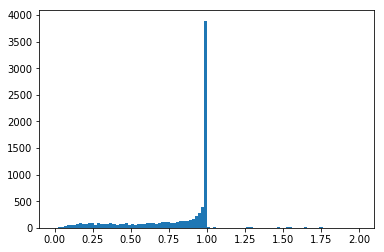

In [160]:
plt.hist(cat2['snr_grpf']/cat2['snr_isof'], range=[1e-5, 2], bins=100);



### old method 

In [24]:
cat = cats['demo2']

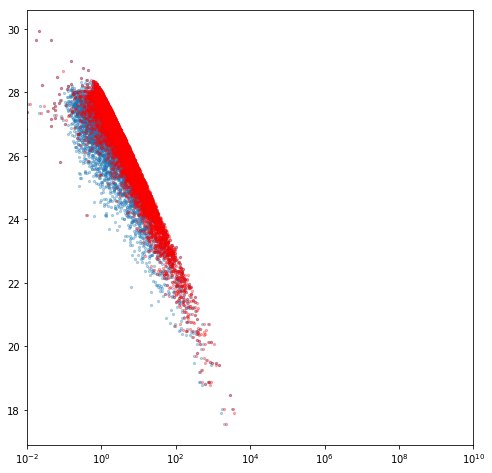

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(cat['snr_grpf'], cat['ab_mag'], alpha=0.3, s=5)
plt.scatter(cat['snr_isof'], cat['ab_mag'], alpha=0.3, s=5, c='r')
plt.xlim(1e-2,1e10)
plt.xscale('log')

In [25]:
print(len(cat[cat['snr_grpf'] > cat['snr_isof']]))
print(len(cat[cat['snr_grpf'] <= cat['snr_isof']]))
#no such effect. 

0
8782


## Look at some of some of the histograms of the whole thing 

(array([4.318e+03, 1.655e+03, 7.400e+02, 3.930e+02, 3.070e+02, 2.250e+02,
        1.400e+02, 1.130e+02, 1.150e+02, 6.200e+01, 4.400e+01, 5.600e+01,
        5.400e+01, 3.500e+01, 3.000e+01, 3.500e+01, 1.700e+01, 2.000e+01,
        2.000e+01, 2.100e+01, 1.200e+01, 2.000e+01, 1.200e+01, 9.000e+00,
        1.100e+01, 1.500e+01, 8.000e+00, 1.100e+01, 9.000e+00, 6.000e+00,
        1.000e+01, 1.100e+01, 7.000e+00, 5.000e+00, 7.000e+00, 2.000e+00,
        4.000e+00, 7.000e+00, 6.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
        4.000e+00, 4.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 5.000e+00, 4.000e+00,
        0.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+0

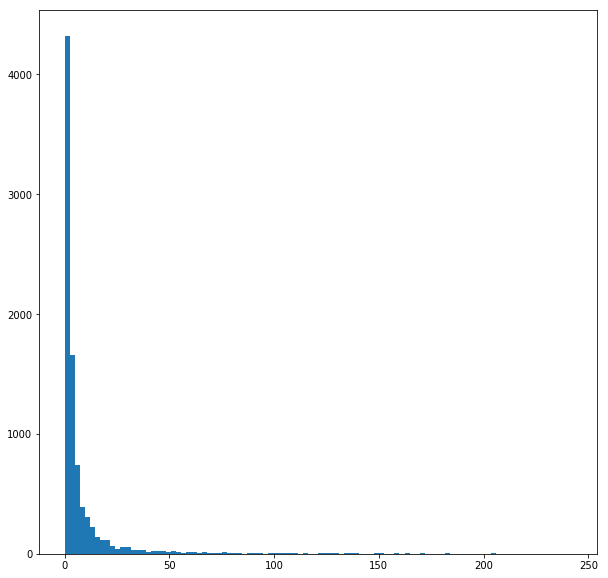

In [79]:
plt.figure(figsize=(10,10))
plt.hist(cat2['snr_grpf'],bins=100, range=(0,np.percentile(cat2['snr_grpf'],99)));

In [95]:
print(len(cat2))
print(len(cat2[cat2['snr_grpf'] > 1e3])/len(cat2))

8782
0.004099294010475973


## Biases 

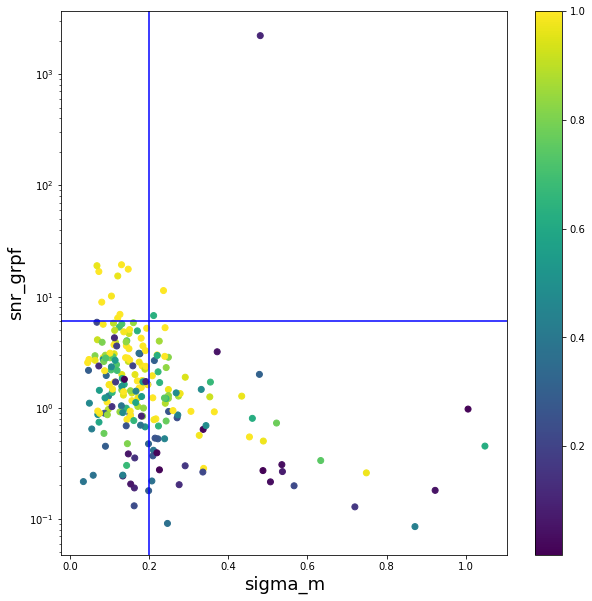

In [116]:
plt.figure(figsize=(10,10))
cat_bad = cat1[cat1['bias_g1_grp'] >1]
#plt.hist(cat_bad['snr_grpf'],bins=100)
#plt.hist(cat_bad['sigma_m'],bins=100)
plt.scatter(cat_bad['sigma_m'], cat_bad['snr_grpf'], c=cat_bad['purity'])
plt.yscale('log')
plt.axvline(0.2,c='b')
plt.axhline(6,c='b')
plt.xlabel('sigma_m', size=18)
plt.ylabel('snr_grpf', size=18)
plt.colorbar()



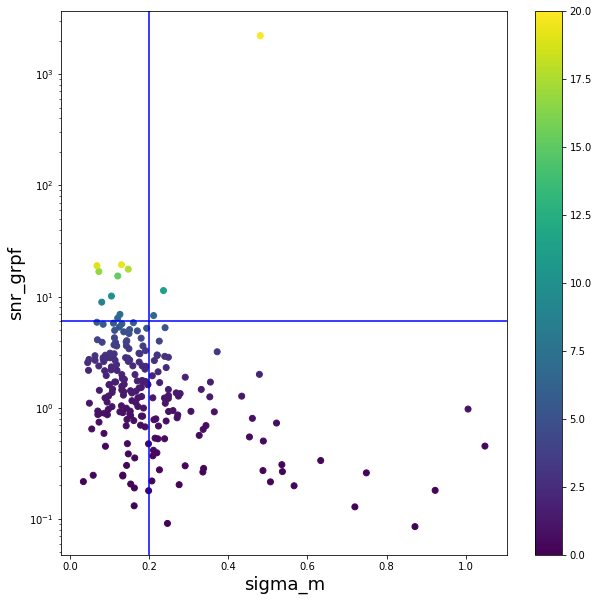

In [124]:
plt.figure(figsize=(10,10))
cat_bad = cat1[cat1['bias_g1_grp'] >1]
#plt.hist(cat_bad['snr_grpf'],bins=100)
#plt.hist(cat_bad['sigma_m'],bins=100)
plt.scatter(cat_bad['sigma_m'], cat_bad['snr_grpf'], c=cat_bad['snr_grpf'], vmax=20, vmin=0)
plt.yscale('log')
plt.axvline(0.2,c='b')
plt.axhline(6,c='b')
plt.xlabel('sigma_m', size=18)
plt.ylabel('snr_grpf', size=18)
plt.colorbar()




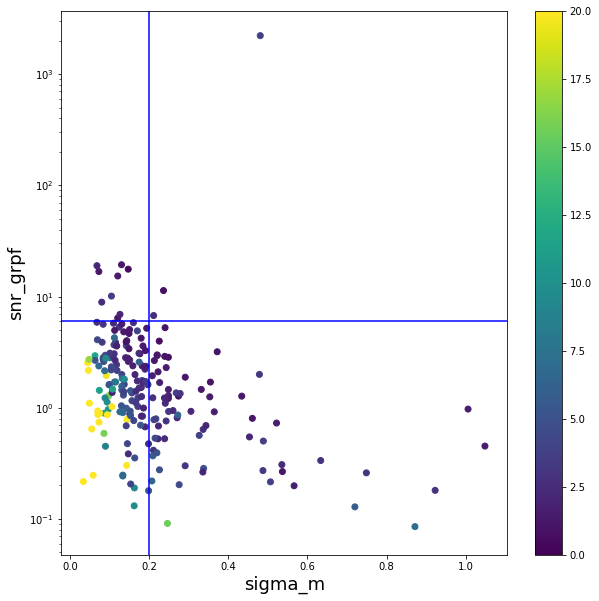

In [128]:
plt.figure(figsize=(10,10))
cat_bad = cat1[cat1['bias_g1_grp'] >1]
#plt.hist(cat_bad['snr_grpf'],bins=100)
#plt.hist(cat_bad['sigma_m'],bins=100)
plt.scatter(cat_bad['sigma_m'], cat_bad['snr_grpf'], c=cat_bad['dg1_grp'], vmax=20, vmin=0)
plt.yscale('log')
plt.axvline(0.2,c='b')
plt.axhline(6,c='b')
plt.xlabel('sigma_m', size=18)
plt.ylabel('snr_grpf', size=18)
plt.colorbar()





In [118]:
cat_not_as_bad = cat_bad[(cat_bad['snr_grpf'] > 6) & (cat_bad['sigma_m'] > 0.2)]

In [119]:
cat_not_as_bad

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402706891398,402700003100,204,86,1,345,357,538,548,1.0,0.0,10.337672,48.654713,0.8767727,26.19399,0.8033905,23678.344,0.21107452,0.2600381,0.35134885,0.28669912,0.34422013,0.12943012,0.34220928,0.66869044,0.6345639,7.007304,6.9965177,6.9906683,4.7519016,6.7431183,1.1900746,0.9660508,0.8483864,2.5275652,2.5114725,2.169634,0.40075755,0.58703965,0.4809426,0.0,0.0,1512.4569,-2.093637,1.9256316,1.5711968,-3.7968905e-05,-6.2338e-05,2554.9414,-13.4009695,9.476831,5.2840333,-0.3399036,-0.6123049
402703732279,402703732279,1,0,1,99,116,12,24,0.9843614,0.015638594,-38.366497,-56.30184,1.3972341,25.200508,0.508091,59121.35,0.23603861,0.37854683,0.6412563,0.16994697,0.5247104,0.1061809,0.1295331,0.713345,1.0,16.803656,16.744177,16.744177,11.311707,11.311707,0.9167153,0.87710863,0.28436735,0.9167153,0.87710863,0.28436735,0.41676873,0.9285118,0.24801561,0.0,0.0,587.4532,-1.2011079,1.5379943,0.40751255,4.4853314e-06,-5.7968487e-07,587.4532,-1.2011079,1.5379943,0.40751255,4.4853314e-06,-5.7968487e-07
402712533640,402700003100,204,172,1,450,459,488,498,0.1453001,0.8546999,30.996132,38.7226,2.1637876,27.146936,0.017354965,9844.032,0.48069766,0.4807645,0.0063490034,-0.00993499,0.4863991,0.47506306,-0.50107694,0.7832761,0.10706019,2.0401204,2.0392478,2.0331807,0.4436015,2214.22,6.076396,2.4552627,2.5009613,2.7830825,3.8217998,4.1851153,0.41718537,0.008091277,-0.038825,0.0,0.0,61442.51,14.223961,-0.56987673,0.7498529,0.00082719215,-0.0013812917,-1.3388999,-19.666622,1.6911278,-0.88827544,1.3100353,-0.82548887


# Display images 

In [29]:
!./WeakLensingDeblending/display.py --input-name demo1_pinv.fits --select 'grp_id==402700140027' \
--clip-lo-noise-fraction 0.05 --magnification 2 --output-name finder1_1_pinv.png 

!./WeakLensingDeblending/display.py --input-name demo2_pinv.fits --select 'grp_id==402700140027' \
--clip-lo-noise-fraction 0.05 --magnification 1 --output-name finder2_1_pinv.png 

Figure(1200x1200)
Figure(1800x1800)


In [90]:
#look at weird object 
!./WeakLensingDeblending/display.py --input-name demo1_pinv_bias.fits --select 'db_id==402716794206' \
--clip-lo-noise-fraction 0.05 --magnification 2 --output-name finder1_2_pinv_bias.png --info '%(db_id).0f' --draw-moments

Figure(1200x1200)


In [169]:
#look at weird object 
!./WeakLensingDeblending/display.py --input-name demo2_pinv.fits --select 'db_id==402700010705' \
--clip-lo-noise-fraction 0.05 --magnification 1 --output-name image3.png --info '%(db_id).0f'

Figure(1800x1800)


# Check the fisher matrices 

In [74]:
def get_fish_matrices(fits_file, grp_id, descwl):
    path = "/Users/Ismael/code/lensing/WLD"
    reader = descwl.output.Reader(os.path.join(path,fits_file))
    results = reader.results
    selected = results.select(f'grp_id=={grp_id}')
    sort_order = np.argsort(results.table['grp_rank'][selected])
    selected = selected[sort_order]
    fisher, cov, var, corr = results.get_matrices(selected)
    return (fisher, cov, var, corr), selected 

## properties of the pseudo inverse are satisfied? 

In [3]:
from scipy.linalg import pinv 
from scipy.linalg import pinv2

In [4]:
path = "/Users/Ismael/code/lensing/WLD"
reader = descwl.output.Reader(os.path.join(path,'demo2_pinv.fits'))

In [5]:
results1 = reader.results
t1p = results1.table
#selected1 = results1.select('grp_id==402700140027')
selected1 = results1.select('grp_id==402700013038')
sort_order1 = np.argsort(results1.table['grp_rank'][selected1])
selected1 = selected1[sort_order1]
fisher1, cov1, var1, corr1 = results1.get_matrices(selected1)

/Users/Ismael/anaconda3/envs/galsim/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


In [7]:
np.diagonal(fisher1)

array([7.96304666e-09, 5.64968870e+06, 5.46330024e+06, 1.42185082e+06,
       1.09609664e+06, 1.09756344e+06, 2.35241147e-08, 5.92649022e+06,
       9.84849596e+06, 5.42408917e+05, 4.53769148e+05, 5.56363741e+05,
       1.86313370e-08, 1.05374160e+06, 1.02878873e+06, 1.62843138e+05,
       1.00301321e+05, 1.00251682e+05, 1.67129264e-08, 3.48432420e+05,
       2.17693980e+05, 2.85144103e+05, 2.00973721e+05, 1.79161598e+05,
       5.52884858e-08, 4.04966199e+05, 5.49540840e+05, 4.58755144e+04,
       4.96387919e+04, 3.91093059e+04, 2.18951075e-08, 1.49229199e+05,
       1.52347848e+05, 2.34423323e+04, 1.32654331e+04, 1.30748707e+04,
       8.04648850e-08, 1.69665761e+05, 2.52607717e+05, 5.84569121e+03,
       4.78945384e+03, 3.90944674e+03, 3.33326177e-08, 5.31527394e+04,
       1.10148917e+05, 2.43458935e+04, 2.83124334e+04, 2.35616323e+04,
       7.07497733e-08, 6.87519103e+04, 1.37370455e+05, 6.52752133e+03,
       5.53002677e+03, 5.82565340e+03, 3.58465094e-08, 3.46695016e+04,
      

In [111]:
np.sort(np.diagonal(fisher1))

array([2.98332352e-09, 3.36666732e-09, 7.96304666e-09, 1.11720768e-08,
       1.27975836e-08, 1.67129264e-08, 1.80564725e-08, 1.86313370e-08,
       1.89427154e-08, 2.18951075e-08, 2.33364821e-08, 2.35241147e-08,
       2.36207072e-08, 2.39630792e-08, 2.52693075e-08, 2.55094336e-08,
       2.96975896e-08, 3.27981434e-08, 3.33326177e-08, 3.50290516e-08,
       3.52453569e-08, 3.58465094e-08, 3.70742680e-08, 3.93732573e-08,
       3.95064384e-08, 4.11732176e-08, 4.43382368e-08, 4.45062365e-08,
       4.47329866e-08, 4.51588876e-08, 4.58137210e-08, 4.68862496e-08,
       4.84149642e-08, 4.86518116e-08, 4.90740557e-08, 4.91395342e-08,
       5.01235194e-08, 5.04233070e-08, 5.16835511e-08, 5.29428271e-08,
       5.43841589e-08, 5.45057094e-08, 5.49560732e-08, 5.52884858e-08,
       5.57191270e-08, 5.62638849e-08, 5.66479472e-08, 5.71261534e-08,
       5.71638033e-08, 5.75986801e-08, 5.82231837e-08, 5.98008881e-08,
       6.03738893e-08, 6.14813119e-08, 6.31691067e-08, 6.32571937e-08,
      

In [112]:
u, s, _ = np.linalg.svd(fisher1)
s

array([9.88920908e+06, 5.88577741e+06, 5.65151951e+06, 5.46177118e+06,
       1.42303855e+06, 1.09780779e+06, 1.09534592e+06, 1.06071373e+06,
       1.02181935e+06, 8.67493228e+05, 6.74261744e+05, 5.60763613e+05,
       3.99779162e+05, 3.03219490e+05, 2.80226008e+05, 2.52758947e+05,
       2.19667735e+05, 2.08124350e+05, 1.77091896e+05, 1.69637576e+05,
       1.66341447e+05, 1.63026216e+05, 1.42390148e+05, 1.37511555e+05,
       1.24302078e+05, 1.00388301e+05, 1.00027503e+05, 8.79415639e+04,
       8.01464249e+04, 6.86173714e+04, 5.16421722e+04, 4.80145779e+04,
       4.21108146e+04, 4.01818676e+04, 3.17049077e+04, 3.15608059e+04,
       2.56475037e+04, 2.00430298e+04, 1.88847310e+04, 1.86480626e+04,
       1.71574350e+04, 1.64454014e+04, 1.48987543e+04, 1.28665732e+04,
       1.27853005e+04, 1.18393274e+04, 1.04972975e+04, 8.38048042e+03,
       7.91937209e+03, 7.89497469e+03, 6.48909580e+03, 5.88489552e+03,
       5.84523410e+03, 5.81289339e+03, 5.79129410e+03, 5.04616488e+03,
      

In [76]:
easyFisher = fisher1
easyCov = scipy.linalg.pinv2(easyFisher);
print(np.linalg.det(easyFisher))
#machine precision means that  cond = 2.220446049250313e-10
#see https://github.com/scipy/scipy/blob/a9fb36bc44bad4bbd2c1a41cb43c6f10925b38ae/scipy/linalg/basic.py#L958
#useful too: https://en.wikipedia.org/wiki/Machine_epsilon
#Machine epsilon gives an upper bound on the relative error due to rounding in floating point arithmetic.

0.0


In [92]:
easyFisher = fisher1
easyCov = scipy.linalg.pinv2(easyFisher, cond =2.220446049250313e-10);
#print(np.linalg.det(easyFisher))

In [97]:
easyFisher = fisher1
easyCov = scipy.linalg.pinv(easyFisher);
#print(np.linalg.det(easyFisher))

In [8]:
easyFisher = fisher1
easyCov = scipy.linalg.pinv2(easyFisher, cond =2.220446049250313e-30);
#print(np.linalg.det(easyFisher))

In [95]:
np.sort(np.diagonal(easyCov))

array([1.01926591e-07, 1.69621911e-07, 6.99999461e-07, 9.51728324e-07,
       9.76339417e-07, 1.06494938e-06, 2.06012517e-06, 2.06663374e-06,
       2.14377874e-06, 2.30378513e-06, 2.90979123e-06, 3.27399365e-06,
       5.24856425e-06, 5.25739272e-06, 6.03354888e-06, 8.84365620e-06,
       9.49390376e-06, 1.06118819e-05, 1.07103419e-05, 1.08756163e-05,
       1.29325104e-05, 1.36972473e-05, 1.86446211e-05, 2.11876791e-05,
       2.63817921e-05, 2.97270522e-05, 3.36379137e-05, 3.46471324e-05,
       3.82633361e-05, 4.19371930e-05, 4.45012401e-05, 4.75695269e-05,
       4.91583978e-05, 5.22011138e-05, 5.71824515e-05, 5.97087746e-05,
       6.22604156e-05, 6.28909493e-05, 6.57960015e-05, 8.06001984e-05,
       1.11491165e-04, 1.37686846e-04, 1.49871986e-04, 1.50244946e-04,
       1.52606613e-04, 1.61793920e-04, 1.81200487e-04, 1.89407870e-04,
       2.06219220e-04, 2.53652474e-04, 2.56286083e-04, 2.72771834e-04,
       2.90449169e-04, 3.14555383e-04, 3.14789030e-04, 3.26918819e-04,
      

7.162531613849276e-08
8165605056.582744


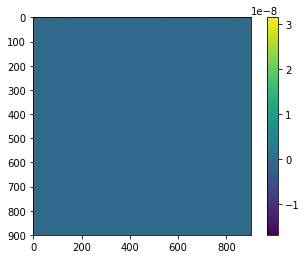

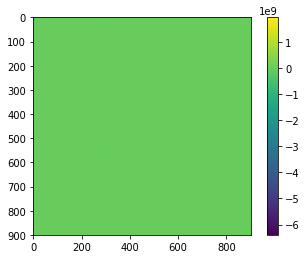

In [9]:
plt.figure()
mat1 = easyFisher - np.dot(easyFisher, np.dot(easyCov, easyFisher))
print(np.linalg.norm(mat1))
plt.imshow(mat1)
plt.colorbar()

plt.figure()
mat2 = easyCov - np.dot(easyCov, np.dot(easyFisher, easyCov))
print(np.linalg.norm(mat2))
plt.imshow(mat2)
plt.colorbar()


# plt.figure(figsize=(4,4))
# plt.imshow(np.dot(easyFisher,easyCov) )
# plt.colorbar()

# plt.figure(figsize=(4,4))
# plt.imshow(np.dot(easyCov,easyFisher) )
# plt.colorbar()

In [12]:
np.allclose(easyCov, np.dot(easyCov, np.dot(easyFisher, easyCov)))

False

In [96]:
cat2_grp

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402700067501,402700140027,77,2,1,953,1048,1276,1375,1.0,0.0,20.174484,85.192154,0.3143966,20.505354,0.28014755,4464841.0,2.5539706,2.6523767,-0.02490784,0.19279124,3.1097693,2.097508,0.84964025,2.6331525,0.96389234,275.9892,272.0976,272.0395,8617323600000000.0,303195750000.0,0.0032418293,0.0042138174,0.004530698,0.0033050377,0.0043918714,0.0047309226,1.7609727,-0.0479282,0.3709957,0.0,0.0
402700140027,402700140027,77,0,1,923,970,1252,1287,0.99082863,0.009171369,9.393194,73.924194,0.6802436,21.373764,0.7788944,2006513.0,0.7852613,0.8711541,0.22111925,0.23353267,1.096036,0.56260496,0.40634724,1.0257179,0.99588656,333.1423,319.7962,319.75928,984272800000000.0,49251013000.0,0.0039751274,0.0048087034,0.004865453,0.0048894417,0.00536012,0.005308535,0.68118167,0.39728445,0.41958982,0.0,0.0
402700197193,402700140027,77,4,1,996,1023,1358,1402,1.0,0.0,21.953268,96.10777,0.4986591,21.986204,0.38643456,1141473.8,0.64913815,0.795981,-0.4406322,0.08362016,1.0520144,0.40054616,1.4770248,0.94820863,0.9114641,215.56862,209.2108,208.90852,123520110000000.0,1470323700.0,0.007737027,0.009920302,0.006512007,0.011253525,0.014163997,0.009693802,0.60902846,-0.7332922,0.13915047,0.0,0.0
402700246589,402700140027,77,1,1,902,935,1238,1270,0.94067144,0.05932856,3.8023539,70.920006,0.6597126,21.790823,0.89626503,1366527.6,0.5316925,0.5655117,0.0066249957,-0.24808009,0.6850731,0.41265222,-0.77204883,0.8283183,0.9994504,286.65582,274.41458,274.41437,259434680000000.0,9422886000.0,0.005713896,0.006673015,0.0076560476,0.0057208855,0.006710977,0.0076691094,0.54507273,0.012187868,-0.45814288,0.0,0.0
402700293644,402700140027,77,3,1,1064,1090,1412,1437,0.9946481,0.0053519066,35.481915,105.03427,1.2313727,22.31187,-0.056287766,845666.94,0.30669358,0.33584508,0.1373505,0.26774418,0.41837525,0.2248244,0.5484048,0.7009104,0.9982192,226.28426,216.83734,216.83202,26145960000000.0,4096422000.0,0.012401208,0.013126307,0.015214321,0.012627446,0.014324506,0.016491232,0.44122863,0.25433436,0.49576065,0.0,0.0
402700317352,402700140027,77,5,1,953,1010,1219,1284,0.0030702716,0.9969297,16.455126,70.38217,2.1285295,22.157358,-0.07343292,974999.3,0.9909661,0.99892664,-0.06497416,-0.06147545,1.0839506,0.90595806,-1.1919281,1.1699818,0.99572355,135.27017,132.44867,132.44861,45411536000000.0,35704880000.0,0.013001101,0.017923813,0.017907983,0.013003217,0.017991217,0.017968344,0.54289377,-0.12521805,-0.11843984,0.0,0.0
402700446626,402700140027,77,6,1,1004,1029,1368,1399,0.9921127,0.007887311,23.39947,96.85869,1.2530944,22.627514,0.15967178,632327.44,0.547211,0.56340945,-0.16995434,0.016717607,0.6502122,0.46052632,1.5217714,0.8317855,0.7986028,130.00232,127.44819,127.17342,31659284000000.0,260167950.0,0.011188972,0.015413131,0.01445506,0.01755957,0.021405563,0.018446762,0.56007284,-0.32633108,0.032088384,0.0,0.0
402700460662,402700140027,77,7,1,984,1007,1356,1379,0.9945671,0.0054329,19.169867,93.55099,1.0962204,22.900455,0.18823433,491773.8,0.32751903,0.32817146,-0.025522804,-0.03658713,0.34247053,0.3132203,-1.0899514,0.7000098,0.97439456,128.85327,125.752426,125.6956,10065390000000.0,575100100.0,0.01595912,0.022051262,0.02209159,0.025681604,0.029114535,0.03812978,0.44968897,-0.050863087,-0.07297879,0.0,0.0
402700699878,402700140027,77,8,1,1020,1043,1407,1428,1.0,0.0,26.44379,103.58996,0.2389378,23.058933,0.48073387,424985.66,0.27141556,0.30360073,0.21424828,-0.25630718,0.3841533,0.19176303,-0.43727136,0.686542,0

## histogram of fisher elements from isolated galaxies. 

In [15]:
fits_file = 'demo2_pinv.fits'
cat = cats['demo2_pinv']
iso_cat = cat[cat['grp_size']==1]

In [16]:
fishers = [] 
for row in tqdm(iso_cat): 
    grp_id = row['grp_id']
    fisher, cov, var, corr = get_fish_matrices(fits_file, grp_id,descwl_pinv)
    fishers.append(fisher)
        

  0%|          | 0/1635 [00:00<?, ?it/s]/Users/Ismael/anaconda3/envs/galsim/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)
100%|██████████| 1635/1635 [24:37<00:00,  1.14it/s] 


In [ ]:
import corner 

In [24]:
#convert into corner format. 
fisher_elems = {} 
for fisher in tqdm(fishers): 
    for i in range(6):
        for j in range(0,i+1): 
            
            if fisher_elems.get((i,j),None) is None: 
                fisher_elems[(i,j)] = [] 
                
            fisher_elems[(i,j)].append(fisher[i,j])

100%|██████████| 1635/1635 [00:00<00:00, 28872.04it/s]


In [48]:
np.quantile([8,9,1,2,3,4,4,5], 0.1)

1.7000000000000002

In [65]:
#alpha is decimal 
def remove_outliers(arr,alpha, tail='symmetric'):
    arr = np.array(arr)


    if tail=='symmetric':
        q1 = np.quantile(arr, alpha/2)
        q2 = np.quantile(arr, 1 - alpha/2)
        return arr[(arr>q1)&(arr<q2)]

    elif tail=='left':
        q1 = np.quantile(arr, alpha)
        return arr[arr>q1]
    
    elif tail=='right':
        q2 = np.quantile(arr, 1 - alpha)
        return arr[arr<q2]
    
    else: 
        raise NotImplementedError() 
    

In [60]:
arr = np.array([8,9,1,2,3,4,4,5])
remove_outliers(arr, .40)

array([3, 4, 4, 5])

In [61]:
remove_outliers(fisher_elems[i,j], 0.1) 

array([8.95364056e-08, 7.70142539e-08, 1.08090310e-07, ...,
       1.00011669e-07, 8.89498155e-08, 7.48892772e-08])

In [140]:
len(fishers)

1635

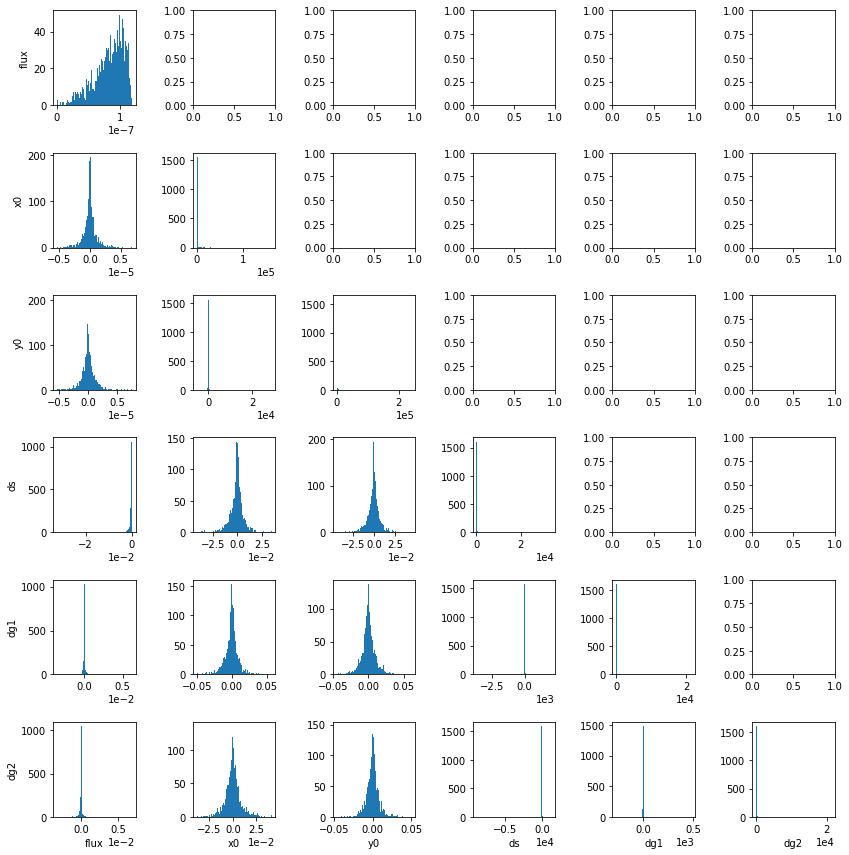

In [142]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(14, 14))
names = ['flux', 'x0', 'y0', 'ds', 'dg1', 'dg2'] #correct order. 
for i in range(6):
    for j in range(0,i+1):
        if i==j:
            tail="right"
        else: 
            tail="symmetric"
            
        axes[i,j].hist(remove_outliers(fisher_elems[i,j],0, tail=tail), bins=100)
        axes[i,j].tick_params(axis='x', which='major', labelsize=10) 
        axes[i,j].ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))
        if j==0:
            axes[i,j].set_ylabel(names[i], size=10)
        if i==5:
            axes[i,j].set_xlabel(names[j], size=10)



fig.subplots_adjust(wspace=0.7,
                    hspace=0.5,
                    left=0.125, right=0.9,
                    top=0.9, bottom=0.1)

In [143]:
np.max(fisher_elems[5,5])

46483.35307011135

In [141]:
cats['demo2_pinv']

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2203976277,402700004461,68,21,0,1799,1811,660,673,0.93393594,0.066064075,181.15312,-46.62104,1.5300165,25.295834,0.29415512,54151.957,0.14967261,0.17560774,-0.3484113,0.19252379,0.22810316,0.09820948,1.3183868,0.64242154,0.85157984,17.053682,16.985838,16.978308,11.675321,11.098506,0.6997997,0.6289176,0.46178624,0.7108191,0.63016826,0.4663395,0.37786797,-0.6153414,0.33989337,0.0,0.0
2202267179,402700004461,68,15,0,1792,1813,667,685,0.97851056,0.02148944,180.61757,-44.749073,1.2138864,24.614803,0.4002838,101397.27,0.4866003,0.50374156,0.14544521,-0.11598354,0.5873746,0.40311554,-0.3365884,0.79346573,0.9177763,22.258047,22.176018,22.171892,13.84339,13.497941,0.11178205,0.095849015,0.0940769,0.11561072,0.099670954,0.09547314,0.5264529,0.27781123,-0.22151823,0.0,0.0
2201759732,402700004461,68,9,0,1794,1813,621,637,0.9732941,0.026705919,180.82611,-54.04035,1.4085618,24.173708,0.45433426,152217.44,0.2606284,0.34095505,0.34252334,-0.3808551,0.4589013,0.14802131,-0.4191693,0.69975436,0.3727337,42.54703,42.174683,41.89469,28.197655,47.51058,0.18441992,0.1300398,0.14079957,0.16211209,0.13201368,0.1447569,0.42206246,0.56769085,-0.63123184,0.0,0.0
2207099445,402700004461,68,33,0,1797,1808,619,630,0.97492105,0.025078967,180.58495,-55.02129,3.1378162,26.1142,0.0983181,25483.986,0.10545703,0.14560167,-0.32749665,-0.45230055,0.19811228,0.056135774,-1.0987469,0.634986,0.22164026,8.336756,8.3197975,8.283306,5.6906857,7.55598,4.964473,3.0458477,4.051092,4.9648848,3.2240808,4.2672963,0.36411238,-0.5078593,-0.7022297,0.0,0.0
2200171828,402700004461,68,1,0,1794,1851,603,660,0.0,1.0,184.67122,-53.629868,0.2230686,21.213142,0.077581406,2326433.5,0.4116164,0.41162255,-0.003176061,-0.0022023348,0.41321036,0.4100286,-1.2676492,0.74286115,0.9872543,485.98456,446.70282,446.57465,189.15279,25594.596,0.012682147,0.00706883,0.007068714,0.0053720796,0.0070826253,0.0070740934,0.4520317,-0.0061540697,-0.004338106,0.0,0.0
2216592648,402702273054,3,2,0,1799,1807,331,339,1.0,0.0,180.70253,-112.82365,2.6126795,27.890837,-0.081207275,4961.499,0.28388464,0.2961392,-0.0541716,0.19824718,0.3496918,0.23046148,0.91876876,0.6847157,0.94184417,1.3474268,1.3470441,1.3470336,0.75194705,0.75116843,3.3544211,2.6538885,2.9581482,3.358527,2.6545603,2.9622512,0.40303263,-0.077876545,0.33582997,0.0,0.0
2200133058,2200133058,1,0,0,1787,1828,383,425,0.95008916,0.049910843,181.56596,-99.040634,0.8176027,21.25777,0.6515446,2232746.2,0.77113897,0.77867985,-0.016582873,-0.09724257,0.8513615,0.69847566,-0.8698513,0.99077237,1.0,371.2695,354.53156,354.53156,215.38078,215.38078,0.005620872,0.0045715403,0.0046600676,0.005620872,0.0045715403,0.0046600676,0.6691061,-0.031683303,-0.18575612,0.0,0.0
2208710180,2208710180,1,0,0,1795,1806,354,363,0.9633044,0.036695573,180.22058,-108.22001,1.0938509,26.687408,0.8215656,15030.873,0.2067694,0.21238534,0.15944697,-0.03699108,0.24390323,0.17528914,-0.113981694,0.65366405,1.0,4.502154,4.497633,4.497633,2.9955769,2.9955769,1.1765443,1.1169746,1.0246769,1.1765443,1.1169746,1.0246769,0.3940969,0.29310974,-0.06786464,0.0,0.0
2213024568,2213024568,1,0,0,1795,1804,440,450,0.95727,0.04272997,180.04724,-90.92309,1.6255093,27.226465,0.22380066,9148.744,0.2718553,0.28727305,-0.048177153,0.22975281,0.34532297,0.2140179,0.8887464,0.6807969,1.0,2.5402615,2.5389085,2.5389085,1.5568204,1.5568204,1.7648833,1.3647252,1.604688,1.7648833,1.3647252,1.604688,0.4140006,-0.07589202,0.40427157,0.0,0.0


## New sanity condition as a function of rcond for pinv and pinv2

In [81]:
from scipy.linalg import pinv 
from scipy.linalg import pinv2

In [75]:
grp_id = '402700140027' #previous infamous group. 
(fisher, cov, var, corr), selected  = get_fish_matrices('demo2_pinv.fits', grp_id, descwl_pinv)

In [78]:
ncats = cats['demo2_pinv'][selected]
ncats

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402700140027,402700140027,77,0,1,923,970,1252,1287,0.99082863,0.009171369,9.393194,73.924194,0.6802436,21.373764,0.7788944,2006513.0,0.7852613,0.8711541,0.22111925,0.23353267,1.096036,0.56260496,0.40634724,1.0257179,0.99588656,333.1423,319.7962,319.75928,199.48543,122.24468,0.0062531433,0.004826958,0.0048855715,0.007578103,0.0066037215,0.007301276,0.68118167,0.39728445,0.41958982,0.0,0.0
402700246589,402700140027,77,1,1,902,935,1238,1270,0.94067144,0.05932856,3.8023539,70.920006,0.6597126,21.790823,0.89626503,1366527.6,0.5316925,0.5655117,0.0066249957,-0.24808009,0.6850731,0.41265222,-0.77204883,0.8283183,0.9994504,286.65582,274.41458,274.41437,172.70123,171.29709,0.008893584,0.006673055,0.007704186,0.008980054,0.0067370487,0.007720087,0.54507273,0.012187868,-0.45814288,0.0,0.0
402700067501,402700140027,77,2,1,953,1048,1276,1375,1.0,0.0,20.174484,85.192154,0.3143966,20.505354,0.28014755,4464841.0,2.5539706,2.6523767,-0.02490784,0.19279124,3.1097693,2.097508,0.84964025,2.6331525,0.96389234,275.9892,272.0976,272.0395,160.24602,124.43556,0.0055024014,0.004213831,0.004531439,0.0065435064,0.005083541,0.0060980283,1.7609727,-0.0479282,0.3709957,0.0,0.0
402700293644,402700140027,77,3,1,1064,1090,1412,1437,0.9946481,0.0053519066,35.481915,105.03427,1.2313727,22.31187,-0.056287766,845666.94,0.30669358,0.33584508,0.1373505,0.26774418,0.41837525,0.2248244,0.5484048,0.7009104,0.9982192,226.28426,216.83734,216.83202,147.13899,111.7665,0.017270545,0.013213122,0.015497196,0.02100052,0.016119255,0.0166021,0.44122863,0.25433436,0.49576065,0.0,0.0
402700197193,402700140027,77,4,1,996,1023,1358,1402,1.0,0.0,21.953268,96.10777,0.4986591,21.986204,0.38643456,1141473.8,0.64913815,0.795981,-0.4406322,0.08362016,1.0520144,0.40054616,1.4770248,0.94820863,0.9114641,215.56862,209.2108,208.90852,133.36282,48.727184,0.011473986,0.010122607,0.006523219,0.019272817,0.019034047,0.012217558,0.60902846,-0.7332922,0.13915047,0.0,0.0
402700317352,402700140027,77,5,1,953,1010,1219,1284,0.0030702716,0.9969297,16.455126,70.38217,2.1285295,22.157358,-0.07343292,974999.3,0.9909661,0.99892664,-0.06497416,-0.06147545,1.0839506,0.90595806,-1.1919281,1.1699818,0.99572355,135.27017,132.44867,132.44861,47.37751,46.857773,0.03625446,0.017935831,0.017918712,0.03665475,0.018054191,0.018025348,0.54289377,-0.12521805,-0.11843984,0.0,0.0
402700446626,402700140027,77,6,1,1004,1029,1368,1399,0.9921127,0.007887311,23.39947,96.85869,1.2530944,22.627514,0.15967178,632327.44,0.547211,0.56340945,-0.16995434,0.016717607,0.6502122,0.46052632,1.5217714,0.8317855,0.7986028,130.00232,127.44819,127.17342,80.481026,27.601057,0.017549455,0.015461512,0.014455559,0.02942436,0.024995696,0.02592131,0.56007284,-0.32633108,0.032088384,0.0,0.0
402700460662,402700140027,77,7,1,984,1007,1356,1379,0.9945671,0.0054329,19.169867,93.55099,1.0962204,22.900455,0.18823433,491773.8,0.32751903,0.32817146,-0.025522804,-0.03658713,0.34247053,0.3132203,-1.0899514,0.7000098,0.97439456,128.85327,125.752426,125.6956,83.56079,13.891766,0.023985317,0.022054559,0.022098351,0.039179858,0.05136392,0.038945008,0.44968897,-0.050863087,-0.07297879,0.0,0.0
402700699878,402700140027,77,8,1,1020,1043,1407,1428,1.0,0.0,26.44379,103.58996,0.2389378,23.058933,0.48073387,424985.66,0.27141556,0.30360073,0.21424828,-0.25630718,0.3841533,0.19176303,-0.43727136,0.686542,0.9961892,118.27971,115.50718,115.50418,78.516815,57.58481,0.03910678,0.03115418,0.033148885,0.05

In [100]:
counts = [] 
snr_grpfss = [] 
rconds = [10**i for i in range(-21,-10)]
for rcond in tqdm(rconds):
    cov = pinv(fisher, rcond=rcond)
    snr_grpfs = ncats['flux']/np.array([np.sqrt(cov[i,i]) for i in range(len(np.diag(cov))) if i%6==0])
    snr_grpfss.append(snr_grpfs)
    counts.append(sum(snr_grpfs > ncats['snr_isof']))

        
    

  0%|          | 0/11 [00:00<?, ?it/s]/Users/Ismael/anaconda3/envs/galsim/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


In [101]:
len(snr_grpfs)

77

In [133]:
counts[2]

0

In [134]:
cov = pinv(fisher, rcond=1e-19)
np.min(np.diag(cov))

-13890898599164.348

In [146]:
np.argmax(snr_grpfss[3])

76

In [147]:
ncats['snr_isof'][76]

1.8096318e-05

In [148]:
ncats

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402700140027,402700140027,77,0,1,923,970,1252,1287,0.99082863,0.009171369,9.393194,73.924194,0.6802436,21.373764,0.7788944,2006513.0,0.7852613,0.8711541,0.22111925,0.23353267,1.096036,0.56260496,0.40634724,1.0257179,0.99588656,333.1423,319.7962,319.75928,199.48543,122.24468,0.0062531433,0.004826958,0.0048855715,0.007578103,0.0066037215,0.007301276,0.68118167,0.39728445,0.41958982,0.0,0.0
402700246589,402700140027,77,1,1,902,935,1238,1270,0.94067144,0.05932856,3.8023539,70.920006,0.6597126,21.790823,0.89626503,1366527.6,0.5316925,0.5655117,0.0066249957,-0.24808009,0.6850731,0.41265222,-0.77204883,0.8283183,0.9994504,286.65582,274.41458,274.41437,172.70123,171.29709,0.008893584,0.006673055,0.007704186,0.008980054,0.0067370487,0.007720087,0.54507273,0.012187868,-0.45814288,0.0,0.0
402700067501,402700140027,77,2,1,953,1048,1276,1375,1.0,0.0,20.174484,85.192154,0.3143966,20.505354,0.28014755,4464841.0,2.5539706,2.6523767,-0.02490784,0.19279124,3.1097693,2.097508,0.84964025,2.6331525,0.96389234,275.9892,272.0976,272.0395,160.24602,124.43556,0.0055024014,0.004213831,0.004531439,0.0065435064,0.005083541,0.0060980283,1.7609727,-0.0479282,0.3709957,0.0,0.0
402700293644,402700140027,77,3,1,1064,1090,1412,1437,0.9946481,0.0053519066,35.481915,105.03427,1.2313727,22.31187,-0.056287766,845666.94,0.30669358,0.33584508,0.1373505,0.26774418,0.41837525,0.2248244,0.5484048,0.7009104,0.9982192,226.28426,216.83734,216.83202,147.13899,111.7665,0.017270545,0.013213122,0.015497196,0.02100052,0.016119255,0.0166021,0.44122863,0.25433436,0.49576065,0.0,0.0
402700197193,402700140027,77,4,1,996,1023,1358,1402,1.0,0.0,21.953268,96.10777,0.4986591,21.986204,0.38643456,1141473.8,0.64913815,0.795981,-0.4406322,0.08362016,1.0520144,0.40054616,1.4770248,0.94820863,0.9114641,215.56862,209.2108,208.90852,133.36282,48.727184,0.011473986,0.010122607,0.006523219,0.019272817,0.019034047,0.012217558,0.60902846,-0.7332922,0.13915047,0.0,0.0
402700317352,402700140027,77,5,1,953,1010,1219,1284,0.0030702716,0.9969297,16.455126,70.38217,2.1285295,22.157358,-0.07343292,974999.3,0.9909661,0.99892664,-0.06497416,-0.06147545,1.0839506,0.90595806,-1.1919281,1.1699818,0.99572355,135.27017,132.44867,132.44861,47.37751,46.857773,0.03625446,0.017935831,0.017918712,0.03665475,0.018054191,0.018025348,0.54289377,-0.12521805,-0.11843984,0.0,0.0
402700446626,402700140027,77,6,1,1004,1029,1368,1399,0.9921127,0.007887311,23.39947,96.85869,1.2530944,22.627514,0.15967178,632327.44,0.547211,0.56340945,-0.16995434,0.016717607,0.6502122,0.46052632,1.5217714,0.8317855,0.7986028,130.00232,127.44819,127.17342,80.481026,27.601057,0.017549455,0.015461512,0.014455559,0.02942436,0.024995696,0.02592131,0.56007284,-0.32633108,0.032088384,0.0,0.0
402700460662,402700140027,77,7,1,984,1007,1356,1379,0.9945671,0.0054329,19.169867,93.55099,1.0962204,22.900455,0.18823433,491773.8,0.32751903,0.32817146,-0.025522804,-0.03658713,0.34247053,0.3132203,-1.0899514,0.7000098,0.97439456,128.85327,125.752426,125.6956,83.56079,13.891766,0.023985317,0.022054559,0.022098351,0.039179858,0.05136392,0.038945008,0.44968897,-0.050863087,-0.07297879,0.0,0.0
402700699878,402700140027,77,8,1,1020,1043,1407,1428,1.0,0.0,26.44379,103.58996,0.2389378,23.058933,0.48073387,424985.66,0.27141556,0.30360073,0.21424828,-0.25630718,0.3841533,0.19176303,-0.43727136,0.686542,0.9961892,118.27971,115.50718,115.50418,78.516815,57.58481,0.03910678,0.03115418,0.033148885,0.05

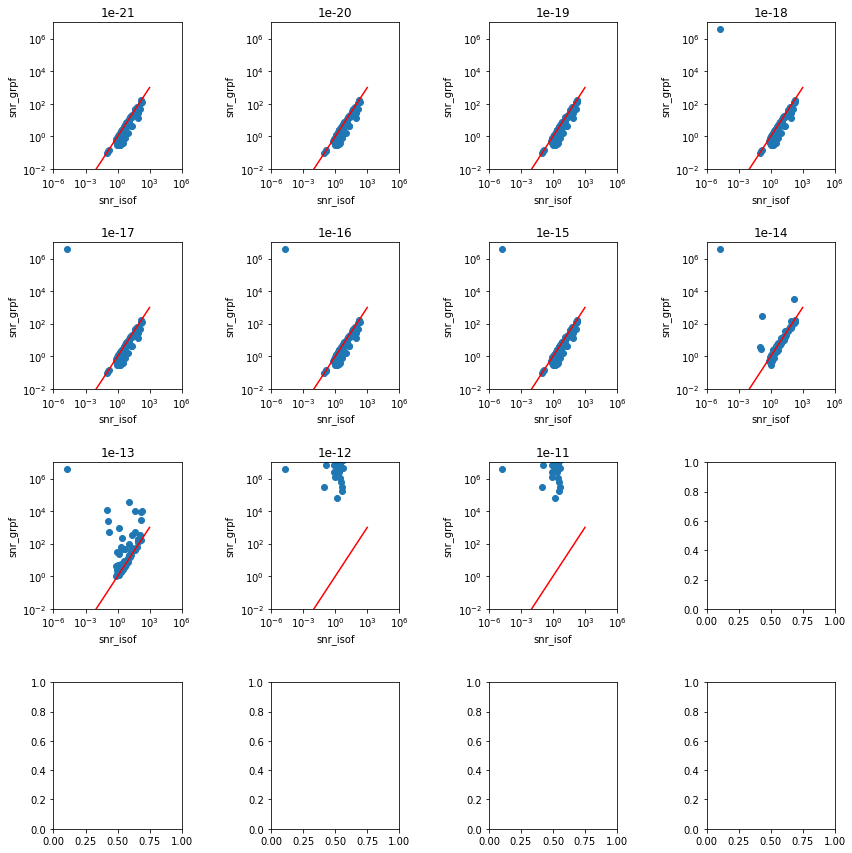

In [149]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))
axs = axes.flatten() 
for ax, snr_grpfs, rcond in zip(axs, snr_grpfss, rconds): 
    ax.scatter(ncats['snr_isof'], snr_grpfs)
#     plt.scatter(snr_grpfs, ncats['ab_mag'], s=5)
#     plt.scatter(ncats['snr_isof'], ncats['ab_mag'], s=5, c='r')
#     plt.xlim(1e-2,1e10)
    ax.set_xlabel('snr_isof')
    ax.set_ylabel('snr_grpf')
    ax.set_title(rcond)
    ax.plot([1e-2,1e3],(1e-2,1e3),color='r')
    ax.set_xlim([1e-6,1e6])
    ax.set_ylim([1e-2,1e7])
    ax.set_xscale('log')
    ax.set_yscale('log')


fig.subplots_adjust(wspace=0.7,
                    hspace=0.5,
                    left=0.125, right=0.9,
                    top=0.9, bottom=0.1)

In [138]:
np.max(snr_grpfss[0])

nan

# How bad is the problem

In [ ]:
#recall interested galaxy db_id = 402700857466
#and group grp_id = 402700140027

In [66]:
cat = cats['demo2']
print('catalogue size:', len(cat))

catalogue size: 8782


5

In [68]:
grps = np.sort(list(set(cat['grp_id'])))

In [70]:
grp_sizes = [cat[cat['grp_id']==i]['grp_size'][0] for i in grps]
dropped = [ sum(cat[cat['grp_id']==i]['snr_grpf']==0) for i in grps ]


28

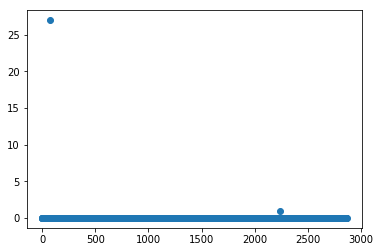

In [74]:
plt.plot(dropped, marker='o', linestyle='')

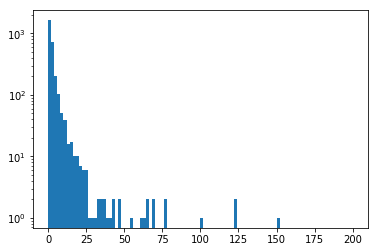

In [48]:
plt.hist(grp_sizes, bins=100, range=[0,200])
plt.yscale('log')

In [49]:
cat

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2203976277,402700004461,68,21,0,1799,1811,660,673,0.93393594,0.066064075,181.15312,-46.62104,1.5300165,25.295834,0.29415512,54151.957,0.14967261,0.17560774,-0.3484113,0.19252379,0.22810316,0.09820948,1.3183868,0.64242154,0.85157984,17.053682,16.985838,16.978308,11.675321,11.107993,0.6997997,0.6289176,0.46178624,0.71058697,0.63019335,0.46630952,0.37786797,-0.6153414,0.33989337,0.0,0.0
2202267179,402700004461,68,15,0,1792,1813,667,685,0.97851056,0.02148944,180.61757,-44.749073,1.2138864,24.614803,0.4002838,101397.27,0.4866003,0.50374156,0.14544521,-0.11598354,0.5873746,0.40311554,-0.3365884,0.79346573,0.9177763,22.258047,22.176018,22.171892,13.84339,13.33981,0.11178205,0.095849015,0.0940769,0.11642582,0.09967742,0.095475376,0.5264529,0.27781123,-0.22151823,0.0,0.0
2201759732,402700004461,68,9,0,1794,1813,621,637,0.9732941,0.026705919,180.82611,-54.04035,1.4085618,24.173708,0.45433426,152217.44,0.2606284,0.34095505,0.34252334,-0.3808551,0.4589013,0.14802131,-0.4191693,0.69975436,0.3727337,42.54703,42.174683,41.89469,28.197655,17.645866,0.18441992,0.1300398,0.14079957,0.2748797,0.20099072,0.20534217,0.42206246,0.56769085,-0.63123184,0.0,0.0
2207099445,402700004461,68,33,0,1797,1808,619,630,0.97492105,0.025078967,180.58495,-55.02129,3.1378162,26.1142,0.0983181,25483.986,0.10545703,0.14560167,-0.32749665,-0.45230055,0.19811228,0.056135774,-1.0987469,0.634986,0.22164026,8.336756,8.3197975,8.283306,5.6906857,3.0696065,4.964473,3.0458477,4.051092,6.544365,3.5392413,5.2704353,0.36411238,-0.5078593,-0.7022297,0.0,0.0
2200171828,402700004461,68,1,0,1794,1851,603,660,0.0,1.0,184.67122,-53.629868,0.2230686,21.213142,0.077581406,2326433.5,0.4116164,0.41162255,-0.003176061,-0.0022023348,0.41321036,0.4100286,-1.2676492,0.74286115,0.9872543,485.98456,446.70282,446.57465,189.15279,188.70776,0.012682147,0.00706883,0.007068714,0.012714079,0.0070842835,0.007074215,0.4520317,-0.0061540697,-0.004338106,0.0,0.0
2216592648,402702273054,3,2,0,1799,1807,331,339,1.0,0.0,180.70253,-112.82365,2.6126795,27.890837,-0.081207275,4961.499,0.28388464,0.2961392,-0.0541716,0.19824718,0.3496918,0.23046148,0.91876876,0.6847157,0.94184417,1.3474268,1.3470441,1.3470336,0.75194705,0.75116843,3.3544211,2.6538885,2.9581482,3.358527,2.6545603,2.9622512,0.40303263,-0.077876545,0.33582997,0.0,0.0
2200133058,2200133058,1,0,0,1787,1828,383,425,0.95008916,0.049910843,181.56596,-99.040634,0.8176027,21.25777,0.6515446,2232746.2,0.77113897,0.77867985,-0.016582873,-0.09724257,0.8513615,0.69847566,-0.8698513,0.99077237,1.0,371.2695,354.53156,354.53156,215.38078,215.38078,0.005620872,0.0045715403,0.0046600676,0.005620872,0.0045715403,0.0046600676,0.6691061,-0.031683303,-0.18575612,0.0,0.0
2208710180,2208710180,1,0,0,1795,1806,354,363,0.9633044,0.036695573,180.22058,-108.22001,1.0938509,26.687408,0.8215656,15030.873,0.2067694,0.21238534,0.15944697,-0.03699108,0.24390323,0.17528914,-0.113981694,0.65366405,1.0,4.502154,4.497633,4.497633,2.9955769,2.9955769,1.1765443,1.1169746,1.0246769,1.1765443,1.1169746,1.0246769,0.3940969,0.29310974,-0.06786464,0.0,0.0
2213024568,2213024568,1,0,0,1795,1804,440,450,0.95727,0.04272997,180.04724,-90.92309,1.6255093,27.226465,0.22380066,9148.744,0.2718553,0.28727305,-0.048177153,0.22975281,0.34532297,0.2140179,0.8887464,0.6807969,1.0,2.5402615,2.5389085,2.5389085,1.5568204,1.5568204,1.7648833,1.3647252,1.604688,1.7648833,1.3647252,1.604688,0.4140006,-0.07589202,0.40427157,0.0,0.0


In [56]:
sum(cat[cat['grp_id']==402700140027]['snr_grpf']==0)

27

In [57]:
cat[cat['grp_id']==402700140027]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402703043805,402700140027,77,16,1,995,1008,1252,1265,1.0,0.0,20.383474,71.74731,0.6398099,24.906548,0.41611862,77504.8,0.067752324,0.08691339,0.38894072,-0.30455494,0.116417944,0.039430153,-0.33215585,0.6244349,0.96682113,26.185843,26.014383,0.0,19.015854,0.0,2.6692564,2.1779017,1.7837086,inf,inf,inf,0.35404444,0.74087584,-0.58536667,0.0,0.0
402700317352,402700140027,77,5,1,953,1010,1219,1284,0.0030702716,0.9969297,16.455126,70.38217,2.1285295,22.157358,-0.07343292,974999.3,0.9909661,0.99892664,-0.06497416,-0.06147545,1.0839506,0.90595806,-1.1919281,1.1699818,0.99572355,135.27017,132.44867,132.44861,47.37751,46.947136,0.03625446,0.017935831,0.017918712,0.036580186,0.018032953,0.018010408,0.54289377,-0.12521805,-0.11843984,0.0,0.0
402712049563,402700140027,77,62,1,993,1004,1222,1233,1.0,0.0,19.77023,65.59636,1.8938355,27.073038,0.09739876,10537.373,0.47755712,0.4837769,0.008216394,-0.11345416,0.53535473,0.42599943,-0.74925107,0.783713,0.78072184,2.3094473,2.3085396,2.3083358,1.2717351,1.2702299,1.2036668,0.9855416,1.0231918,1.2041899,0.9856307,1.0232862,0.5039048,0.00696199,-0.20649022,0.0,0.0
402706865901,402700140027,77,33,1,953,964,1228,1238,1.0,0.0,11.8779125,66.676,0.8493703,26.146076,0.77157784,24746.69,0.109531835,0.12632972,0.36767495,0.08083813,0.16273776,0.07372119,0.108209826,0.63105565,0.90084845,8.1243105,8.108181,8.10712,5.7870955,5.756344,2.406607,2.3740065,1.3472981,2.4145415,2.3782125,1.3511406,0.36350206,0.6372579,0.14418612,0.0,0.0
402700768092,402700140027,77,9,1,956,980,1214,1236,0.92059404,0.07940595,13.6579895,65.07687,0.9846882,23.111479,0.67048836,404907.72,0.33703348,0.38603926,0.16899775,-0.32614204,0.49547234,0.22925915,-0.5463584,0.72291684,0.9965755,103.624,101.62278,101.61907,66.1057,65.81801,0.038213026,0.02653944,0.03327565,0.038301945,0.02656047,0.033344425,0.45548218,0.30069527,-0.5802535,0.0,0.0
402714675302,402700140027,77,64,1,986,995,1385,1394,1.0,0.0,18.197002,98.00174,4.296076,27.49894,0.47927856,7118.226,0.23881188,0.25215003,-0.0036370128,-0.23298371,0.30279267,0.1883504,-0.7932028,0.66716146,0.45376337,2.0498757,2.0489635,2.0483081,1.2865539,0.5149025,2.4509914,1.898276,2.2966251,3.1229148,2.575732,2.9650729,0.39938864,-0.0054946174,-0.39342806,0.0,0.0
402710835421,402700140027,77,48,1,995,1004,1390,1399,1.0,0.0,19.903696,98.952095,2.158897,26.877106,0.017402649,12621.335,0.08908094,0.10780932,0.1234404,-0.41629133,0.14182803,0.05595095,-0.64126575,0.62764835,0.85483605,4.201079,4.196677,4.1962113,2.9942446,2.9754105,8.084601,3.979511,7.839518,8.098677,3.9842,7.844511,0.35662702,0.14605826,-0.56859773,0.0,0.0
402700816955,402700140027,77,10,1,987,1015,1392,1428,0.86107886,0.13892116,20.323393,102.04415,1.280879,23.135595,0.50860786,396013.03,0.72288203,0.871628,-0.16890927,0.39551574,1.1450833,0.4563497,0.98720556,1.000092,0.97990566,69.312355,68.64918,68.64681,40.583027,40.2637,0.035864145,0.021784585,0.029102411,0.03610603,0.021889446,0.029196452,0.6302268,-0.28320184,0.6631359,0.0,0.0
402707740766,402700140027,77,39,1,983,995,1389,1400,1.0,0.0,17.87472,98.97227,1.5344297,26.26904,0.039274216,22096.93,0.27646264,0.276996,-0.025326122,0.03585917,0.2888781,0.26458076,1.0928577,0.6775608,0.34381735,6.13581,6.128047,6.117669,4.013421,0.9999234,0.5878911,0.546735,0.54673344,1.1544102,1.3474967,1.1885791,0.42462367,-0.04841143,0.06743389,0.0,0.0


In [58]:
cat[cat['db_id']==402700857466]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402700857466,402700140027,77,11,1,1035,1066,1415,1434,0.96156365,0.038436327,30.20778,105.035774,1.5986731,23.44294,0.5132847,298381.34,0.46015733,0.6118579,0.50931984,-0.13437444,0.82650155,0.25619406,-0.12897663,0.83122915,0.9966413,67.43038,66.66593,66.665764,42.77398,42.767895,0.057377957,0.05204395,0.026899638,0.057384606,0.052045614,0.026902288,0.5125568,0.81264263,-0.2143985,0.0,0.0
